# PART III
## Kernel perceptron

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from helpers import *

np.random.seed(1234)  # give a fixed seed for reproducability
from sklearn.model_selection import train_test_split

In [2]:
#loading data
zipcombo = np.loadtxt('zipcombo.dat')
zipcombo_qater = zipcombo[:len(zipcombo)//4]
training_data = np.loadtxt('dtrain123.dat')
test_data = np.loadtxt('dtest123.dat')

#some training data is continuous, need to make sure everything is either -1 or 1

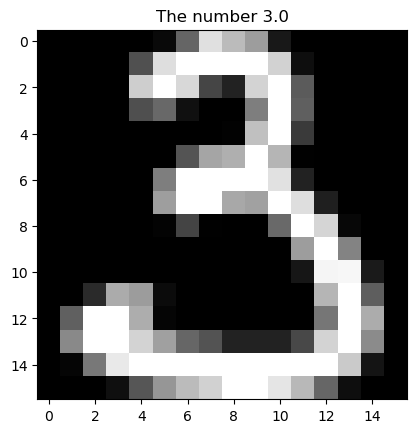

In [3]:
#plot first char
def plot_char(char):
    data = char[1:].reshape(16, 16)
    plt.imshow(data, cmap='gray')
    plt.title(f"The number {char[0]}")
    plt.show()
    
plot_char(training_data[0])

In [4]:
##helper functions(can be extracted into a separate class later)

#polynomial kernel

def polynomial_kernel(p, q, d):
    return (1 + (p@q.T)) ** d

def polynomial_kernel_3D(p, q, d):
    #returns a 3D array of the polynomial kernel of the data, last dimension is the degree
    kernels = np.empty((len(d), len(q), len(p)))
    for i, degree in enumerate(d):
        kernels[i, :, :] = (1 + np.dot(p, q.T)) ** degree

    return kernels

#Gaussian kernel
def gaussian_kernel(p, q, sigma):
    #from previous coursework: exp(-||p-q||^2 / 2*sigma^2)
    return np.exp(-np.linalg.norm(p - q) ** 2 / (2 * sigma ** 2))

#convering the data to -1 and 1
def mysign(data):
    return np.where(data <= 0.0, -1.0, 1.0)

#splitting data and labels
def split_into_data_and_labels(data):
    y = data[:,0].astype(int)
    #convert to -1 and 1 here instead of in the loop
    x = data[:, 1:]
    return x, y

In [5]:
def train_kernel_perceptron_online(X, y, K, n_classes, return_training_error=True):
    NB_EPOCHS_MAX = 30
    num_samples = X.shape[0]
    alpha = np.zeros((n_classes, num_samples))
    total_mistakes = 0
    prev_error = float('inf') 
    epoches = 0
    for epoch in range(NB_EPOCHS_MAX):
        for i in range(num_samples):
            scores = np.zeros(n_classes)

            # for c in range(n_classes):
            #     y_c = np.where(y == c, 1, -1)  # Binary labels for class c vs. all other classes
            #     scores[c] = np.sum(alpha[c, :] * y_c * K[i, :])
            
            scores = K[i]@alpha.T
            predicted_class = np.argmax(scores)
            true_class = y[i]

            if predicted_class != true_class:
                alpha[true_class, i] += 1
                alpha[predicted_class, i] -=1
                total_mistakes += 1  # Increment the total number of mistakes
                
        epoches+=1
                    
        print(f"Epoches {epoches}, number of sumples {num_samples}, total mistakes {total_mistakes}")
        
        train_error = total_mistakes / (epoches * num_samples)  # Calculate the training error
        
        # convergence
        if (prev_error - train_error) < 1e-2:
            break
        prev_error = train_error
    if(return_training_error):
        return alpha, train_error
    
    return alpha

In [6]:
def predict_kernel_perceptron(y, alpha, K, return_labels=False):
    # Calculate the scores for all test samples and classes at once
    scores = np.dot(alpha, K.T)

    # Predict the class with the highest score for each test sample
    y_pred = np.argmax(scores, axis=0)

    test_error = np.mean(y != y_pred)
    if(return_labels):
        return test_error, y_pred
    return test_error

## Q1

In [7]:
N_RUNS = 20
d_range = np.arange(1, 8, dtype=int)  # k = 1...7
#substitute for the real data with 10
x_data, y_labels = split_into_data_and_labels(zipcombo_qater)
#can be extraced from data
n_classes = len(np.unique(y_labels))

def run_experiment(x_data, y_labels, N_RUNS, d, n_classes):
    train_errors = np.zeros((N_RUNS, len(d_range)))
    train_errors2 = np.zeros((N_RUNS, len(d_range)))
    test_errors = np.zeros((N_RUNS, len(d_range)))

    for i_run in range(N_RUNS):
        X_train, X_test, y_train, y_test = train_test_split(
            x_data, y_labels, test_size=0.2, random_state=i_run
        )
        n_training_samples = X_train.shape[0]

        for j_ind, j in enumerate(d_range):
            K_train = polynomial_kernel(X_train, X_train, j)
            
            alpha, train_errors[i_run, j_ind] = train_kernel_perceptron_online(X_train, y_train, K_train, n_classes)
            train_errors2[i_run, j_ind] = predict_kernel_perceptron(y_train, alpha, K_train)

            print(f"Run {i_run}, degree {j}, train error {train_errors[i_run, j_ind]}, number of samples {n_training_samples}")
            
            # calculating prediction of the test data
            K_test = polynomial_kernel(X_test, X_train, j)
            test_errors[i_run, j_ind] = predict_kernel_perceptron(y_test, alpha, K_test)
            print(f"Run {i_run}, degree {j}, test error {test_errors[i_run, j_ind]}, number of samples {len(X_test)}")

    mean_train_errors = np.mean(train_errors, axis=0)
    mean_test_errors = np.mean(test_errors, axis=0)
    mean_std_train_errors = np.std(train_errors, axis=0)
    mean_std_test_errors = np.std(test_errors, axis=0)
    
    return mean_train_errors, mean_test_errors, mean_std_train_errors, mean_std_test_errors

mean_train_errors, mean_test_errors, mean_std_train_errors, mean_std_test_errors = run_experiment(x_data, y_labels, N_RUNS, d_range, n_classes)

Epoches 1, number of sumples 1859, total mistakes 366
Epoches 2, number of sumples 1859, total mistakes 540
Epoches 3, number of sumples 1859, total mistakes 699
Epoches 4, number of sumples 1859, total mistakes 821
Epoches 5, number of sumples 1859, total mistakes 929
Epoches 6, number of sumples 1859, total mistakes 1024
Run 0, degree 1, train error 0.09180563026716873, number of samples 1859
Run 0, degree 1, test error 0.09462365591397849, number of samples 465
Epoches 1, number of sumples 1859, total mistakes 268
Epoches 2, number of sumples 1859, total mistakes 355
Epoches 3, number of sumples 1859, total mistakes 409
Epoches 4, number of sumples 1859, total mistakes 443
Epoches 5, number of sumples 1859, total mistakes 463
Run 0, degree 2, train error 0.049811726734803656, number of samples 1859
Run 0, degree 2, test error 0.04516129032258064, number of samples 465
Epoches 1, number of sumples 1859, total mistakes 225
Epoches 2, number of sumples 1859, total mistakes 289
Epoches 

In [8]:
# Create a summary table
columns = ['degree', 'mean training error', 'mean train std', 'mean test error', 'mean test std']

# Take an average over all the runs
kernel_perceptron = pd.concat((
    pd.DataFrame(mean_train_errors, columns=[columns[1]]),
    pd.DataFrame(mean_std_train_errors,columns=[columns[2]]),
    pd.DataFrame(mean_test_errors, columns=[columns[3]]),
    pd.DataFrame(mean_std_test_errors, columns=[columns[4]])), axis=1
)
kernel_perceptron.set_index('Polynomial degree ' + pd.Series(d_range).astype(str), inplace=True)
kernel_perceptron.index.name = 'degree'
kernel_perceptron = kernel_perceptron.style.format("{:.5f}")

kernel_perceptron


,mean training error,mean train std,mean test error,mean test std
degree,,,,
Polynomial degree 1,0.09015,0.00334,0.08957,0.01165
Polynomial degree 2,0.04678,0.00216,0.04935,0.01010
Polynomial degree 3,0.03662,0.00144,0.04462,0.00873
Polynomial degree 4,0.03145,0.00188,0.04086,0.00790
Polynomial degree 5,0.02925,0.00090,0.04473,0.00982
Polynomial degree 6,0.02900,0.00189,0.04462,0.00860
Polynomial degree 7,0.02834,0.00166,0.04602,0.00755


## Q2

In [9]:
N_FOLDS = 5
fold_test_prediction_error = np.zeros(shape=(N_RUNS, N_FOLDS, len(d_range)))
test_errors = np.zeros(shape=(N_RUNS))
d_stars = []

for i_run in range(N_RUNS):
    # Use i_run as random state so each run is different but the test_train_split matches the runs
    X_train, X_test, Y_train, Y_test = train_test_split(
        x_data, y_labels, test_size= 0.2, random_state=i_run
    )

    folds_data: list[FoldData] = create_folds_data(X_train, Y_train, number_of_folds=N_FOLDS)

    # Loop to pick the best d_star based on the lowest cross validation error
    for i_fold, fold in enumerate(folds_data):
        fold: FoldData
        for i_j, j in enumerate(d_range):
            K_train_fold = polynomial_kernel(fold.train_data, fold.train_data, j)
            K_test_fold = polynomial_kernel(fold.test_data, fold.train_data, j)
            alpha = train_kernel_perceptron_online(fold.train_data, fold.train_labels, K_train_fold, n_classes, return_training_error = False)

            fold_test_prediction_error[i_run, i_fold, i_j] = predict_kernel_perceptron(fold.test_labels, alpha, K_test_fold)

    # Pick the d star based on the lowest test error
    d_star, _ = get_d_star_from_cross_validation_error(fold_test_prediction_error[i_run, :, :], ds=d_range)
    d_stars.append(d_star)

    # Create a new classifier based on d star and retrained on the whole training set
    K_train = polynomial_kernel(X_train, X_train, d=d_star)
    alpha_star = train_kernel_perceptron_online(X_train, Y_train, K_train, n_classes, return_training_error=False)

    # Get the error of the new training and testing over the whole dataset for this new predictor
    K_test = polynomial_kernel(X_test, X_train, d=d_star)
    test_errors[i_run] = predict_kernel_perceptron(Y_test, alpha_star, K_test)

Epoches 1, number of sumples 1488, total mistakes 341
Epoches 2, number of sumples 1488, total mistakes 505
Epoches 3, number of sumples 1488, total mistakes 628
Epoches 4, number of sumples 1488, total mistakes 737
Epoches 5, number of sumples 1488, total mistakes 828
Epoches 6, number of sumples 1488, total mistakes 898
Epoches 7, number of sumples 1488, total mistakes 971
Epoches 1, number of sumples 1488, total mistakes 259
Epoches 2, number of sumples 1488, total mistakes 328
Epoches 3, number of sumples 1488, total mistakes 364
Epoches 4, number of sumples 1488, total mistakes 384
Epoches 5, number of sumples 1488, total mistakes 402
Epoches 6, number of sumples 1488, total mistakes 406
Epoches 1, number of sumples 1488, total mistakes 215
Epoches 2, number of sumples 1488, total mistakes 256
Epoches 3, number of sumples 1488, total mistakes 275
Epoches 4, number of sumples 1488, total mistakes 280
Epoches 5, number of sumples 1488, total mistakes 284
Epoches 1, number of sumples

In [10]:
d_stars
test_errors
print(d_stars)
print(test_errors)
mean_cross_validation_test_error = np.mean(test_errors, axis=0)
mean_cross_validation_test_error_std = np.std(test_errors, axis=0)
mean_cross_validation_d = np.mean(d_stars)
mean_cross_validation_s_std = np.std(d_stars)
print("Mean Test Error: ", mean_cross_validation_test_error, "±", mean_cross_validation_test_error_std)
print("Mean Best d: ", mean_cross_validation_d, "±", mean_cross_validation_s_std)

part_2_results = {
        "Mean Best d": mean_cross_validation_d,
        "Std Best d": mean_cross_validation_s_std,
        "Mean Test Error": mean_cross_validation_test_error,
        "Std Test Error": mean_cross_validation_test_error_std
    }

df_mean_error_rates = pd.DataFrame(mean_cross_validation_d, index=np.arange(10), columns=np.arange(10))
df_std_error_rates = pd.DataFrame(mean_cross_validation_s_std, index=np.arange(10), columns=np.arange(10))

df_restuls_2 = pd.DataFrame.from_dict(part_2_results, orient='index')
df_restuls_2.reset_index(inplace=True)
df_restuls_2

[4, 4, 4, 6, 3, 7, 4, 7, 5, 4, 4, 6, 4, 4, 4, 5, 4, 4, 5, 5]
[0.04086022 0.03655914 0.02580645 0.04301075 0.04946237 0.04516129
 0.02795699 0.04516129 0.03870968 0.04086022 0.04086022 0.03655914
 0.04516129 0.04516129 0.03870968 0.04516129 0.06021505 0.04301075
 0.04301075 0.04731183]
Mean Test Error:  0.04193548387096774 ± 0.007116297680763139
Mean Best d:  4.65 ± 1.061838029079765


,index,0
0,Mean Best d,4.650000
1,Std Best d,1.061838
2,Mean Test Error,0.041935
3,Std Test Error,0.007116


## Q3

In [11]:
def confusion_matrix(y_true, y_pred):
    classes = np.unique(y_true)
    matrix = np.zeros((len(classes), len(classes)))

    for true_class in classes:
        for pred_class in classes:
            if true_class != pred_class:  # Exclude diagonal elements
                matrix[true_class, pred_class] = np.sum((y_true == true_class) & (y_pred == pred_class)) / np.sum(y_true == true_class)

    return matrix

def calculate_std_dev(confusion_matrices):
    return np.std(confusion_matrices, axis=0)

In [12]:
fold_test_prediction_error = np.zeros(shape=(N_RUNS, N_FOLDS, len(d_range)))
test_errors = np.zeros(shape=(N_RUNS))
test_errors = np.zeros(shape=(N_RUNS))
confusion_matrices = np.zeros(shape=(N_RUNS, n_classes, n_classes))


for i_run in range(N_RUNS):
    # Use i_run as random state so each run is different but the test_train_split matches the runs
    X_train, X_test, Y_train, Y_test = train_test_split(
        x_data, y_labels, test_size= 0.2, random_state=i_run
    )

    folds_data: list[FoldData] = create_folds_data(X_train, Y_train, number_of_folds=N_FOLDS)

    # Loop to pick the best d_star based on the lowest cross validation error
    for i_fold, fold in enumerate(folds_data):
        fold: FoldData
        for i_j, j in enumerate(d_range):
            K_train_fold = polynomial_kernel(fold.train_data, fold.train_data, j)
            K_test_fold = polynomial_kernel(fold.test_data, fold.train_data, j)
            alpha = train_kernel_perceptron_online(fold.train_data, fold.train_labels, K_train_fold, n_classes, return_training_error = False)

            fold_test_prediction_error[i_run, i_fold, i_j] = predict_kernel_perceptron(fold.test_labels, alpha, K_test_fold)

    # Pick the d star based on the lowest test error
    d_star, _ = get_d_star_from_cross_validation_error(fold_test_prediction_error[i_run, :, :], ds=d_range)

    # Create a new classifier based on d star and retrained on the whole training set
    K_train = polynomial_kernel(X_train, X_train, d=d_star)
    alpha_star = train_kernel_perceptron_online(X_train, Y_train, K_train, n_classes, return_training_error=False)

    # Get the error of the new training and testing over the whole dataset for this new predictor
    K_test = polynomial_kernel(X_test, X_train, d=d_star)
    test_errors[i_run], y_pred = predict_kernel_perceptron(Y_test, alpha_star, K_test, return_labels=True)
    confusion_matrices[i_run, :, :] = confusion_matrix(Y_test, y_pred)

Epoches 1, number of sumples 1488, total mistakes 341
Epoches 2, number of sumples 1488, total mistakes 505
Epoches 3, number of sumples 1488, total mistakes 628


Epoches 4, number of sumples 1488, total mistakes 737
Epoches 5, number of sumples 1488, total mistakes 828
Epoches 6, number of sumples 1488, total mistakes 898
Epoches 7, number of sumples 1488, total mistakes 971
Epoches 1, number of sumples 1488, total mistakes 259
Epoches 2, number of sumples 1488, total mistakes 328
Epoches 3, number of sumples 1488, total mistakes 364
Epoches 4, number of sumples 1488, total mistakes 384
Epoches 5, number of sumples 1488, total mistakes 402
Epoches 6, number of sumples 1488, total mistakes 406
Epoches 1, number of sumples 1488, total mistakes 215
Epoches 2, number of sumples 1488, total mistakes 256
Epoches 3, number of sumples 1488, total mistakes 275
Epoches 4, number of sumples 1488, total mistakes 280
Epoches 5, number of sumples 1488, total mistakes 284
Epoches 1, number of sumples 1488, total mistakes 199
Epoches 2, number of sumples 1488, total mistakes 237
Epoches 3, number of sumples 1488, total mistakes 249
Epoches 4, number of sumples

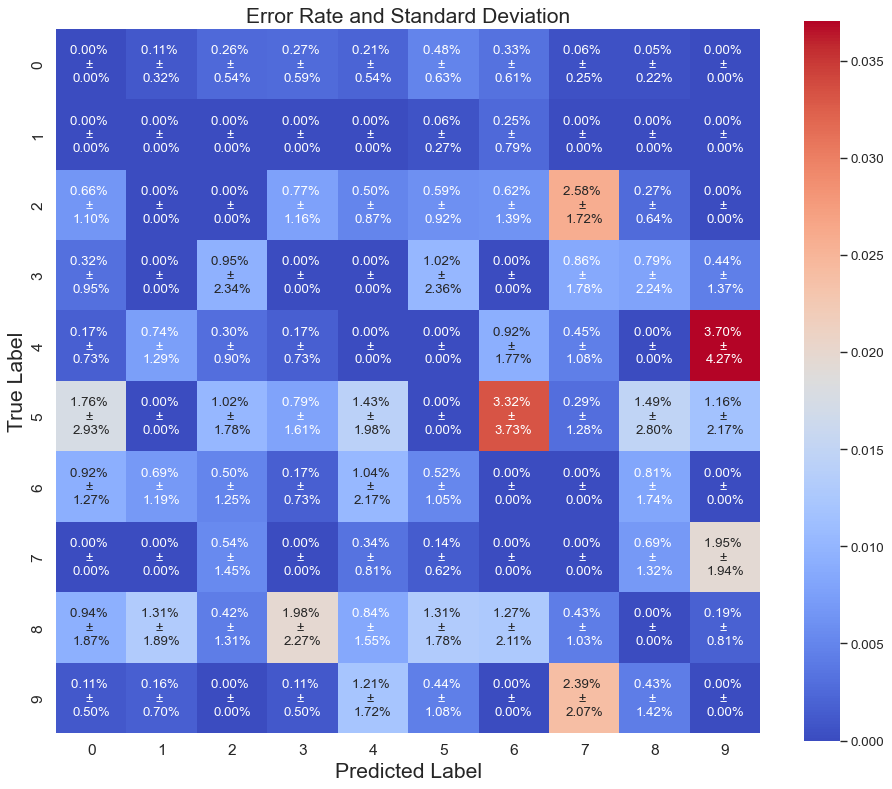

In [27]:
std_dev_matrix = calculate_std_dev(confusion_matrices)
mean_confusion_matrix = confusion_matrices.mean(axis=0)
combined_matrix = np.vectorize(lambda mean, std: f"{mean*100:.2f}% \n± \n{std*100:.2f}%")(mean_confusion_matrix, std_dev_matrix)

plt.figure(figsize=(12, 10), dpi=80)
sns.set(style="whitegrid", font_scale=1.1)
ax = sns.heatmap(mean_confusion_matrix, annot=combined_matrix, fmt="", cmap='coolwarm', cbar=True, square=True, annot_kws={"size": 12}, xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.title("Confusion matrix")
plt.title("Error Rate and Standard Deviation", fontsize=19)
plt.xlabel('Predicted Label', fontsize=19)
plt.ylabel('True Label', fontsize=19)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

## Q4

In [ ]:
## BAD CODE DEMO

# Function to compute the polynomial kernel of degree 3
def compute_kernel(a, b):
    return (np.dot(a, b))**3

# Function to compute the sign of a number
def compute_sign(x):
    return -1.0 if x <= 0.0 else 1.0

# Function to initialize the classifier weights
def initialize_weights(data):
    return np.zeros((3, len(data)))

# Function to compute the prediction for a given pattern
def compute_prediction(data, pattern, classifier):
    return sum(classifier[i] * compute_kernel(pattern, data[i][1:]) for i in range(len(classifier)))

# Function to train the classifiers
def train_classifiers(data):
    global classifier_weights
    classifier_weights = initialize_weights(data)
    num_mistakes = 0

    for i in range(len(data)):
        true_class = data[i][0]

        # Compute the predictions of the 3 classifiers
        predictions = [compute_prediction(data, data[i][1:], classifier_weights[j]) for j in range(3)]
        
        max_prediction = float("-inf")
        for j in range(3):
            expected_output = 1.0 if true_class == (j + 1) else -1.0
            
            # Update the classifier weights if the prediction is incorrect
            if expected_output * predictions[j] <= 0:
                classifier_weights[j, i] -= compute_sign(predictions[j])
            if predictions[j] > max_prediction:
                max_prediction = predictions[j]
                predicted_class = j + 1
                
        # Increment the mistake counter if the predicted class is not the true class
        if predicted_class != true_class:
            num_mistakes += 1

    return num_mistakes

# Train the model and get the number of mistakes
mistakes = train_classifiers(training_data)
print("Number of mistakes:", mistakes)

# Access the global variable GLBcls after training
print("GLBcls shape:", classifier_weights.shape)

Number of mistakes: 15
GLBcls shape: (3, 329)
